In [1]:
import qif
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

## SUP2

In [2]:
def confusion_matrix(flow):
    flow['pred'] = flow['direct_flow'] > flow['reverse_flow']
    flow['pred'] = flow['pred'].replace({True:"direct", False:"reverse"})
    
    return flow[['label', 'pred']].groupby(['label', 'pred']).size().unstack().fillna(0)

In [3]:
df_info = pd.read_csv("data/ce_pairs_sup/CEdata_train_publicinfo.csv")
df_info.columns = ['sample_id', 'a_type', 'b_type']

# target 1: Target [1 for A->B; -1 otherwise]
# target 2: Details [1 for A->B; 2 for A<-B; 3 for A-B; 4 for A|B]']
df_target = pd.read_csv("data/ce_pairs_sup/CEdata_train_target.csv")
df_target.columns = ['sample_id', 'target', 'details']

In [4]:
df_info.head()

,sample_id,a_type,b_type
0,train1,Binary,Numerical
1,train2,Numerical,Numerical
2,train3,Numerical,Numerical
3,train4,Numerical,Categorical
4,train5,Numerical,Binary


In [5]:
df_target.head()

,sample_id,target,details
0,train1,-1,2
1,train2,-1,2
2,train3,0,4
3,train4,-1,2
4,train5,-1,2


In [6]:
df_info = df_info.merge(df_target)
dfs = df_info.query("a_type != 'Numerical' and b_type != 'Numerical' and (details == 1 or details == 2)")

In [7]:
data = []

for i, row in dfs.iterrows():
    filename = "data/SUP2data_split/" + row['sample_id'] + ".txt"
    
    df_sample = pd.read_csv(filename, sep="\t", header=None)
    df_sample.columns = ['a', 'b']
    
    bayes_leakage = qif.BayesLeakage(df_sample)
    direct_flow, reverse_flow = bayes_leakage.compute_flows(x='a', y='b', leakage_type='additive')
    corr = np.corrcoef(df_sample['a'], df_sample['b'])[0][1]
    
    data.append([row['sample_id'], direct_flow, reverse_flow, row['target'], corr])
    
flows = pd.DataFrame(data, columns=['sample_id', 'direct_flow', 'reverse_flow', 'target', 'correlation'])
flows['label'] = flows['target'].replace({1:'Causal', -1:'Anticausal'})

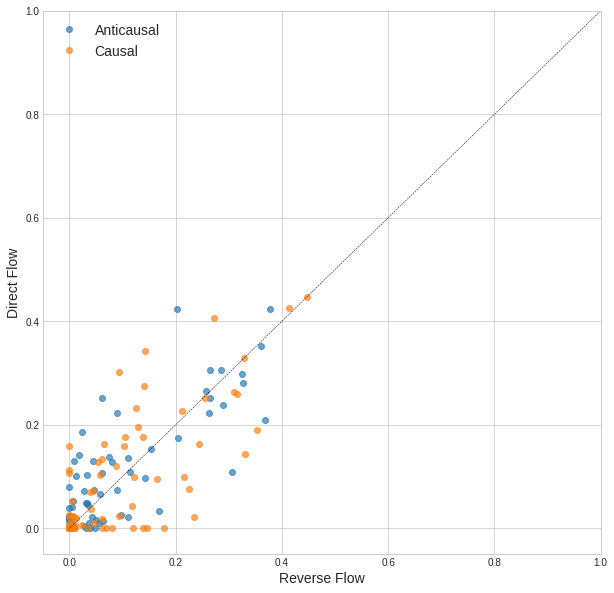

In [14]:
plt.figure(figsize=(10, 10))

groups = flows.groupby("label")
for name, group in groups:
    plt.plot(group['reverse_flow'], group['direct_flow'], marker="o", linestyle="", label=name, alpha=0.66)
plt.plot([0.0, 3], [0.0, 3], color='black', linewidth=0.5, linestyle='dashed')
plt.xlabel("Reverse Flow", fontsize=14)
plt.ylabel("Direct Flow", fontsize=14)
plt.xlim([-0.05, 1])
plt.ylim([-0.05, 1])
plt.legend(fontsize=14)
plt.savefig("sup.png", dpi=120)
#plt.show()

In [12]:
flows

,sample_id,direct_flow,reverse_flow,target,correlation,label,pred
0,train33,0.239030,0.288915,-1,-0.710503,Anticausal,reverse
1,train55,0.000000,0.000000,-1,0.042254,Anticausal,reverse
2,train80,0.000000,0.000199,-1,0.027841,Anticausal,reverse
3,train95,0.022921,0.000000,-1,-0.373236,Anticausal,direct
4,train159,0.067379,0.057518,-1,0.134898,Anticausal,direct
...,...,...,...,...,...,...,...
145,train5790,0.000000,0.081006,1,-0.264298,Causal,reverse
146,train5839,0.000000,0.146840,1,-0.429960,Causal,reverse
147,train5871,0.353015,0.360553,-1,0.983858,Anticausal,reverse
148,train5888,0.000000,0.031522,-1,-0.130131,Anticausal,reverse


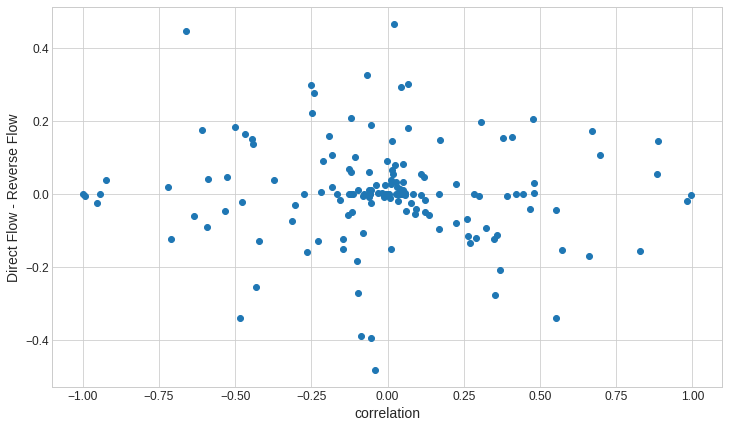

In [22]:
plt.figure(figsize=(12, 7))
plt.scatter(flows['correlation'], flows['direct_flow']-flows['reverse_flow'])
plt.xlabel("correlation", fontsize=14)
plt.ylabel("Direct Flow - Reverse Flow", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [11]:
confusion_matrix(flows)

pred,direct,reverse
label,,
Anticausal,36,39
Causal,33,42


## WEBDAV

In [10]:
filename = "data/pairs/pairmeta.txt"
pairmeta = pd.read_csv(filename, sep=" ", header=None, dtype=str)
pairmeta.columns = ['suffix', 'label', 'x1', 'x2', 'x3', 'x4']
pairmeta.query("label == '1' or label == '2'", inplace=True)
pairmeta.drop(columns=['x1', 'x2', 'x3', 'x4'], inplace=True)

In [11]:
def check_category(df_sample, threshold=0.2):
    n_x = df_sample.x.nunique()/df_sample.shape[0]
    n_y = df_sample.y.nunique()/df_sample.shape[0]
    
    if n_x < threshold and n_y < threshold:
        return True
    else:
        return False

In [16]:
data = []

for suf, label in pairmeta.values:
    filename = "data/pairs/pair" + suf + ".txt"
    
    try:
        df_sample = pd.read_csv(filename, sep=" ", header=None)
        
        if df_sample.shape[1] == 1:
            df_sample = pd.read_csv(filename, sep="\t", header=None)

        if df_sample.shape[1] == 2:
            df_sample.columns = ['x', 'y']
            
            if check_category(df_sample, threshold=0.1):
                bayes_leakage = qif.BayesLeakage(df_sample)
                direct_flow, reverse_flow = bayes_leakage.compute_flows(x='x', y='y')

                data.append([suf, label, direct_flow, reverse_flow])
    except:
        pass

In [17]:
flows_pairs = pd.DataFrame(data, columns=['base', 'label', 'direct_flow', 'reverse_flow'])
flows_pairs['label'] = flows_pairs['label'].replace({'1':'Causal', '2':'Anticausal'})

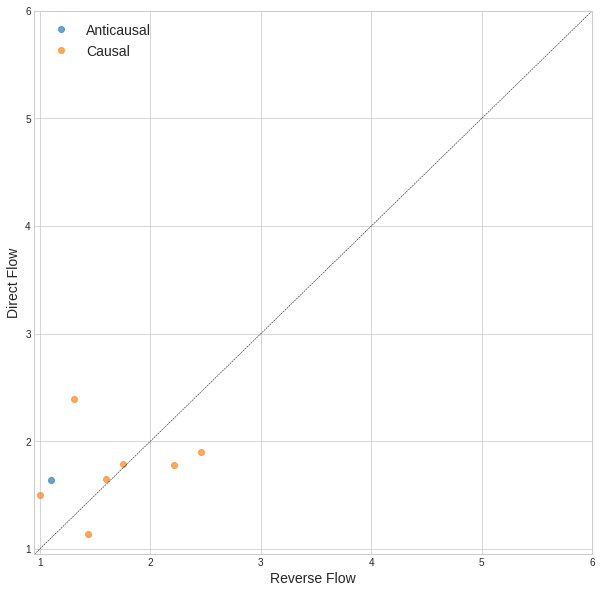

In [18]:
plt.figure(figsize=(10, 10))

groups = flows_pairs.groupby("label")
for name, group in groups:
    plt.plot(group['reverse_flow'], group['direct_flow'], marker="o", linestyle="", label=name, alpha=0.66)
plt.plot([0.95, 6], [0.95, 6], color='black', linewidth=0.5, linestyle='dashed')
plt.xlabel("Reverse Flow", fontsize=14)
plt.ylabel("Direct Flow", fontsize=14)
plt.xlim([0.95, 6])
plt.ylim([0.95, 6])
plt.legend(fontsize=14)
#plt.show()
plt.savefig("webdav.png", dpi=120)

In [15]:
confusion_matrix(flows_pairs)

pred,direct,reverse
label,,
Anticausal,1.0,0.0
Causal,11.0,6.0
